In [8]:
import warnings
warnings.filterwarnings('ignore')


### Affine transformation

Why affine qform and sform tranformations are important?
*sform* allows full 12 parameter affine transfrom to be encoded, however *qform* 9 parameter is limited to encoding
translations, rotations (via a quaternion representation) and isotropic zooms.

In [9]:
import nilearn
from nilearn import plotting
from nilearn import image
from nilearn.datasets import load_mni152_template
import nibabel as nib


Before you can start with a second level analysis you are facing the problem that all your output from the first level analysis are still in their subject specific subject-space. Because of the huge differences in brain size and cortical structure, it is very important to transform the data of each subject from its individual subject-space into a common standardized reference-space. This process of transformation is what we call normalization and it consists of a rigid body transformation (translations and rotations) as well as of a affine transformation (zooms and shears). The most common template that subject data is normalized to is the MNI template.

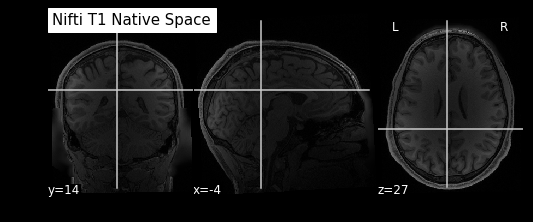

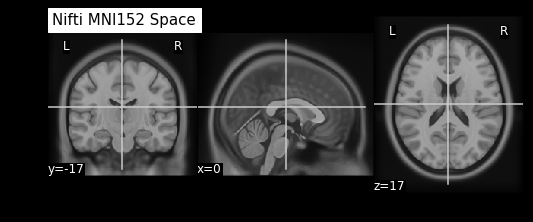

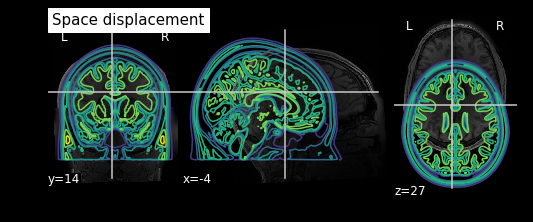

In [19]:
nii_file = nib.load('/workspace/data/raw/100206/unprocessed/3T/T1w_MPR1/100206_3T_T1w_MPR1.nii.gz')

mni_space_template = nib.load('/workspace/data/mni_icbm152_t1_tal_nlin_sym_09a.nii')  # Full template

nilearn.plotting.plot_anat(nii_file,
                           title='Nifti T1 Native Space')

nilearn.plotting.plot_anat(mni_space_template,
                           title='Nifti MNI152 Space')

diff = nilearn.plotting.plot_anat(nii_file,
                           title='Space displacement')
diff.add_contours(mni_space_template, threshold=70)


In [12]:
print("""Affine comparison before transform:
- T1 native image affine:\n {0}
- MNI Space template brain:\n {1}
""".format(nii_file.affine, mni_space_template.affine))


Affine comparison before transform:
- T1 native image affine:
 [[-6.99810445e-01 -1.05695827e-02 -1.23907495e-02  9.24809952e+01]
 [-9.90547892e-03  6.98962629e-01 -3.67843062e-02 -5.84997063e+01]
 [-1.29278088e-02  3.65990102e-02  6.98922992e-01 -1.06281731e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
- MNI Space template brain:
 [[   1.    0.    0.  -98.]
 [   0.    1.    0. -134.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]



In [15]:
print("""Shape comparison before transform:
- T1 native image affine:\n {0}
- MNI Space template brain:\n {1}
""".format(nii_file.shape, mni_space_template.shape))


Shape comparison before transform:
- T1 native image affine:
 (256, 320, 320)
- MNI Space template brain:
 (197, 233, 189)



### Methods
#### ANTz Registration

In [14]:
from nipype.interfaces.ants import RegistrationSynQuick
reg = RegistrationSynQuick()
reg.inputs.fixed_image = '/workspace/data/mni_icbm152_t1_tal_nlin_sym_09a.nii'
reg.inputs.moving_image = '/workspace/data/raw/100206/unprocessed/3T/T1w_MPR1/100206_3T_T1w_MPR1.nii.gz'
reg.inputs.output_prefix = 'subject_name'
print(reg.cmdline)
reg.run()


antsRegistrationSyNQuick.sh -d 3 -f /home/yarkin/code/NEUROML2020/data/mni_icbm152_t1_tal_nlin_sym_09a.nii -r 32 -m /home/yarkin/code/NEUROML2020/data/raw/100206/unprocessed/3T/T1w_MPR1/100206_3T_T1w_MPR1.nii.gz -n 1 -o subject_name -p d -s 26 -t s
200903-10:12:51,205 nipype.interface INFO:
	 stdout 2020-09-03T10:12:51.205508:
200903-10:12:51,207 nipype.interface INFO:
	 stdout 2020-09-03T10:12:51.205508:--------------------------------------------------------------------------------------
200903-10:12:51,208 nipype.interface INFO:
	 stdout 2020-09-03T10:12:51.205508: Mapping parameters
200903-10:12:51,209 nipype.interface INFO:
	 stdout 2020-09-03T10:12:51.205508:--------------------------------------------------------------------------------------
200903-10:12:51,209 nipype.interface INFO:
	 stdout 2020-09-03T10:12:51.205508: ANTSPATH is /usr/lib/ants
200903-10:12:51,210 nipype.interface INFO:
	 stdout 2020-09-03T10:12:51.205508:
200903-10:12:51,211 nipype.interface INFO:
	 stdout 20

#### ANTs initialize + ANTs transform

ANTs initialize affine between two spaces and outputs transformation matrix
ANTs Transform takes affine matrix and output target space image

In [20]:
from nipype.interfaces.ants import AffineInitializer
init = AffineInitializer()
init.inputs.fixed_image = '/workspace/data/mni_icbm152_t1_tal_nlin_sym_09a.nii'
init.inputs.moving_image = '/workspace/raw/100206/unprocessed/3T/T1w_MPR1/100206_3T_T1w_MPR1.nii.gz'
init.inputs.out_file = '/workspace/data/transfm/transfm.mat'
print(init.cmdline)
init.run()


antsAffineInitializer 3 /home/yarkin/code/NEUROML2020/data/mni_icbm152_t1_tal_nlin_sym_09a.nii /home/yarkin/code/NEUROML2020/data/raw/100206/unprocessed/3T/T1w_MPR1/100206_3T_T1w_MPR1.nii.gz /home/yarkin/code/NEUROML2020/data/transfm/transfm.mat 15.000000 0.100000 0 10


In [22]:
from nipype.interfaces.ants import ApplyTransforms
at = ApplyTransforms()
at.inputs.input_image = '/workspace/data/raw/100206/unprocessed/3T/T1w_MPR1/100206_3T_T1w_MPR1.nii.gz'
at.inputs.reference_image = '/workspace/data/mni_icbm152_t1_tal_nlin_sym_09a.nii'
at.inputs.transforms = '/workspace/data/transfm/transfm.mat'
at.inputs.output_image = './sub-100206_MNI159_space.nii.gz'
at.inputs.interpolation = 'Linear'
print(at.cmdline)
at.run()


antsApplyTransforms --default-value 0 --float 0 --input /home/yarkin/code/NEUROML2020/data/raw/100206/unprocessed/3T/T1w_MPR1/100206_3T_T1w_MPR1.nii.gz --interpolation Linear --output ./sub-100206_MNI159_space.nii.gz --reference-image /home/yarkin/code/NEUROML2020/data/mni_icbm152_t1_tal_nlin_sym_09a.nii --transform /home/yarkin/code/NEUROML2020/data/transfm/transfm.mat


In [23]:
nii_file_mni152_antsreg = nib.load('./sub-100206_MNI159_space.nii.gz')
nii_file_mni152_antstransform = nib.load('./subject_nameWarped.nii.gz')
print("""Affine comparison after transform:
- T1 native after transform:\n {0}
- MNI Space template:\n {1}
- T1 native after transform with affine: \n {2}
""".format(nii_file_mni152_antsreg.affine, mni_space_template.affine, nii_file_mni152_antstransform.affine))


Affine comparison after transform:
- T1 native after transform:
 [[   1.    0.   -0.  -98.]
 [   0.    1.   -0. -134.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
- MNI Space template:
 [[   1.    0.    0.  -98.]
 [   0.    1.    0. -134.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
- T1 native after transform with affine: 
 [[   1.    0.   -0.  -98.]
 [   0.    1.   -0. -134.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]



In [24]:
print("""Shape comparison after transform:
- T1 native after transform:\n {0}
- MNI Space template brain:\n {1}
- T1 native after transform with antstransform: \n {2}
""".format(nii_file_mni152_antsreg.shape, mni_space_template.shape, nii_file_mni152_antstransform.shape))


Shape comparison after transform:
- T1 native after transform:
 (197, 233, 189)
- MNI Space template brain:
 (197, 233, 189)
- T1 native after transform with antstransform: 
 (197, 233, 189)



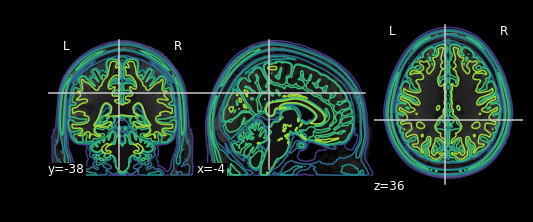

In [25]:
antstransform_result = nilearn.plotting.plot_anat(nii_file_mni152_antsreg)
antstransform_result.add_contours(mni_space_template, threshold=70, title='Nifti MNI152 Space')


In [ ]:
import nilearn
from nilearn import plotting

nilearn.plotting.view_img(nii_file, bg_img=mni_space_template, threshokd='auto')

### File formats convertation - volume-to-volume

You can convert file from preprocessing freesurfer to mni and t1 spaces, using antsTransform with fresurfer native command: *mri_convert*

In [48]:
!mri_convert --in_type mgz --out_type nii --out_orientation RAS \
            /home/yarkin/code/NEUROML2020/data/fs_preproc/100206/mri/T1.mgz \
            /home/yarkin/code/NEUROML2020/T1_fs_preprocessed.nii

mri_convert.bin --in_type mgz --out_type nii --out_orientation RAS /home/yarkin/code/NEUROML2020/data/fs_preproc/100206/mri/T1.mgz /home/yarkin/code/NEUROML2020/T1_fs_preprocessed.nii 
$Id: mri_convert.c,v 1.226 2016/02/26 16:15:24 mreuter Exp $
reading from /home/yarkin/code/NEUROML2020/data/fs_preproc/100206/mri/T1.mgz...
TR=2400.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 2.91038e-10, 1.86265e-09)
j_ras = (1.86265e-09, -3.72529e-09, -1)
k_ras = (-4.07454e-10, 1, 0)
Setting output orientation to RAS
Reslicing using trilinear interpolation 
writing to /home/yarkin/code/NEUROML2020/T1_fs_preprocessed.nii...


In [49]:
freesurfer_t1 = nib.load('./T1_fs_preprocessed.nii')

In [50]:
freesurfer_t1.shape
freesurfer_t1.affine

array([[ 1.00000000e+00,  0.00000000e+00,  1.51788283e-18,
        -1.28768402e+02],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        -8.18190613e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        -1.18252960e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

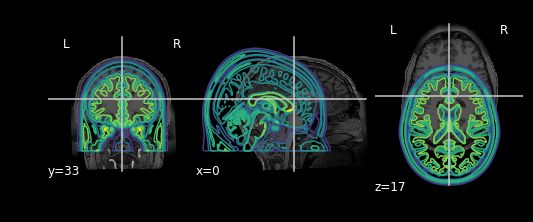

In [41]:
freesurfer_plot = nilearn.plotting.plot_anat(freesurfer_t1)
freesurfer_plot.add_contours(mni_space_template)

In [51]:
import os
#  Implement ANTs registration to allign mni and freesurfer template

#  PUT YOUR CODE HERE

reg = RegistrationSynQuick()
reg.inputs.moving_image = os.path.abspath('./T1_fs_preprocessed.nii')
reg.inputs.fixed_image = os.path.abspath('...')
...

TraitError: Each element of the 'fixed_image' trait of a RegistrationSynQuickInputSpec instance must be a pathlike object or string representing an existing file, but a value of '/home/yarkin/code/NEUROML2020/...' <class 'str'> was specified.

#### Tips:
1) Run a bias correction before antsRegistration (i.e. N4). It helps getting better registration.

2) Remove the skull before antsRegistration. If you have two brain-only images, you can be sure that surrounding tissues (i.e. the skull) will not take a toll on the registration accuracy. If you are using these skull-stripped versions, you can avoid using the mask, because you want the registration to use the "edge" features. If you use a mask, anything out of the mask will not be considered, the algorithm will try to match what's inside the brain, but not the edge of the brain itself (see Nick's explanation here).

3) Never register a lesioned brain with a healthy brain without a proper mask. The algorithm will just pull the remaining parts of the lesioned brain to fill "the gap". Despite initial statements that you can register lesioned brains without the need to mask out the lesion, there is evidence showing that results without lesion masking are sub-optimal. If you really don't have the lesion mask, even a coarse and imprecise drawing of lesions helps (see Andersen 2010).

4) Don't forget to read the parts of the manual related to registration.